# Graphene with Aberration Correction (SVD)

In [42]:
import ase
import matplotlib.pyplot as plt
import abtem
import numpy as np
from ase.lattice.hexagonal import Graphene

# Simulate data with ABTEM

The abtem documentation can be useful: https://abtem.readthedocs.io/en/latest/user_guide/walkthrough/atomic_models.html

## setup structure with ASE and ABTEM

We use atomic simulation environment (ASE) to create a graphene model. The cell size will be direcly related to the sampling of the diffraction pattern. Abtem requires a orthogonal cell, which can be easily generated .

First use the ASE graphene function to make a graphene structure, single unit cell

In [43]:
lc = 2.46 #lattice constant
vac = 0.5 

structure = Graphene(symbol='C', latticeconstant={'a':lc, 'c':vac},
                      size=(1,1,1))

show the structure using abtem

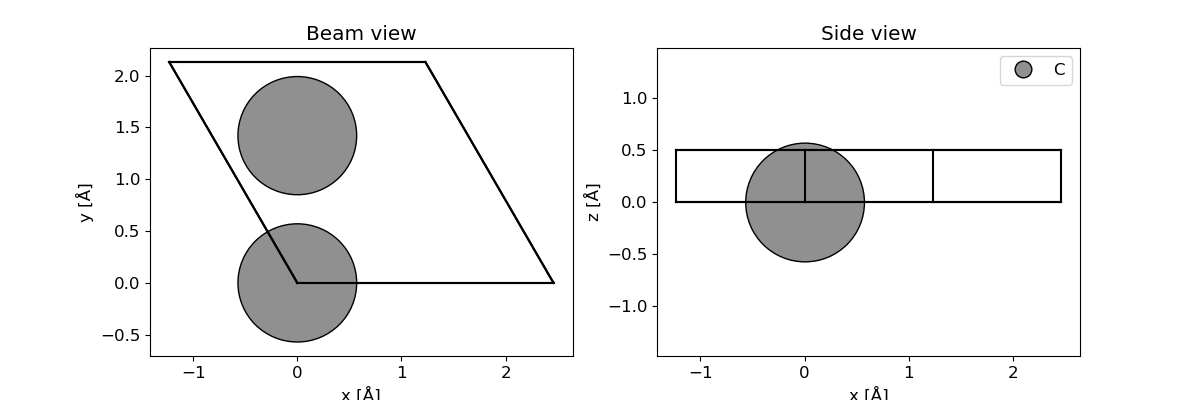

In [44]:
#unit cell of graphene, non-orthogonal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(structure, title="Beam view", ax=ax1)
abtem.show_atoms(structure, legend=True, plane="xz", title="Side view", ax=ax2);

now we convert it to an orthoganal unit cell

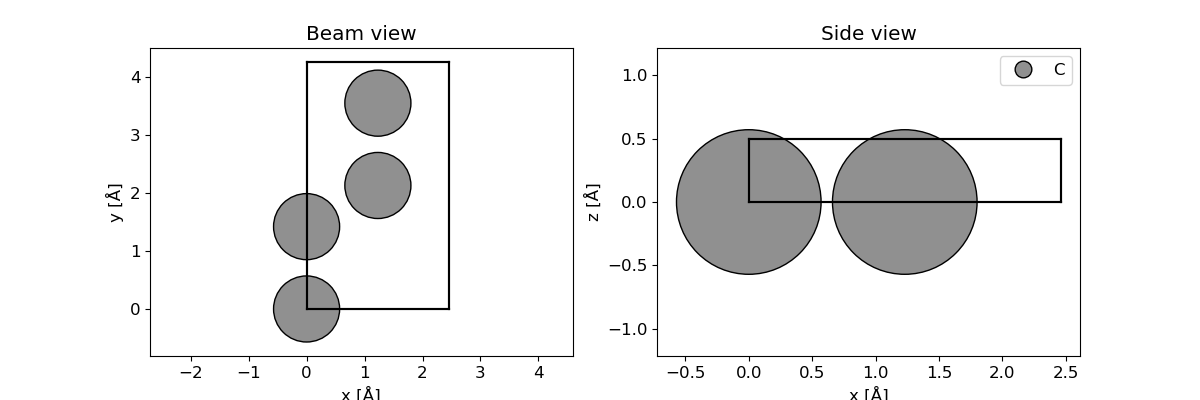

In [45]:
# Orthogonalize cell of graphene
atoms = abtem.orthogonalize_cell(structure)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, title="Beam view", ax=ax1)
abtem.show_atoms(atoms, legend=True, plane="xz", title="Side view", ax=ax2);


expand the structure in multiples of the unit cell

/var/folders/p_/6k4bw65x6zg9jyhcg9wyxv680000gp/T/ipykernel_71547/784356782.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  atoms*=(15,8,1)


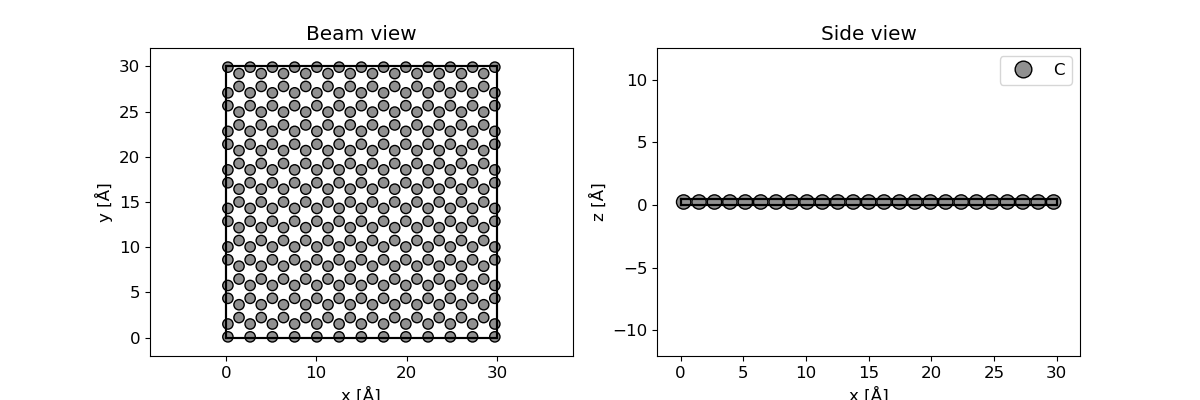

In [46]:
#enlarge the cell
atoms*=(15,8,1)
atoms = abtem.atoms.cut_cell(atoms,cell = (30,30,0.5))

atoms.center()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, title="Beam view", ax=ax1)
abtem.show_atoms(atoms, legend=True, plane="xz", title="Side view", ax=ax2);

In [47]:
# can read and write the structure like this
#atoms.write('graphene_orthogonal.xyz')
#atoms = ase.io.read('graphene_orthogonal.xyz')

Make the cell quadradic due to computational reasons

In [48]:
atoms.cell[1,1] = atoms.cell[0,0]
atoms.center()

### Calculate the multislice potential from structure 

[########################################] | 100% Completed | 117.31 ms


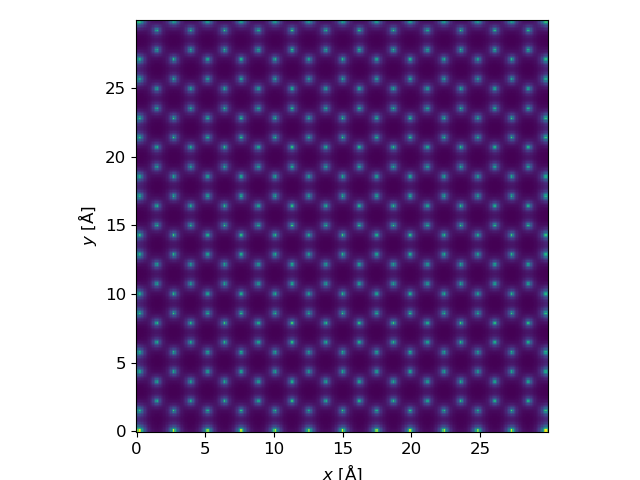

In [49]:
potential = abtem.Potential(atoms,sampling=0.1,slice_thickness=1)
potential.show()


## Define and Calculate the probe

Next we define the probe. Optionally, aberrations can be defined. Units are Angstrom. In an aberration-corrected microscope, first orders are usually below 10 nm, second orders below 100 nm, third orders below 5 $\mu$m and higher orders below 1 mm.

In [55]:
energy = 60e3 #eV   #beam energy
semiangle_cutoff=35 #mrad  convergence angle

aberrations = {'C10':100, #Angstroms!
               'C12':300, 
               'phi12':0, 
               'C21':0, 
               'phi21':0, 
               'C23':0, 
               'phi23':0, 
               'C30':0, 
               'C32':0, 
               'phi32':0, 
               'C34':0, 
               'phi34':0, 
               'C41':0, 
               'phi41':0, 
               'C43':0,
               'phi43':0, 
               'C45':0, 
               'phi45':0, 
               'C50':0, 
               'C52':0, 
               'phi52':0, 
               'C54':0, 
               'phi54':0, 
               'C56':0, 
               'phi56':0}

aberrations = {"C10": 100, 
               "C12": 8, "phi12": -0.5, 
               "C21": 50, "phi21": 0.1,
               "C23": 50, "phi23": 0.4,
               "C30": 1e5, 
               "C32": 2e4, "phi32": 0.9,
               "C34": 2e4, "phi34": 0.4,
              }



### partial temporal coherence / defocus spread

We can also include partial spatial/temporal decoherence for more realistic simulations. The focal spread can be calculated from the chromatic aberrations, but here it is set to 3 nm, a value calulated for a cold FEG source microscope. 
Note: to turn it off do it in the calculate probe cell after this

In [56]:
focal_spread = 30 #A

defocus_distribution = abtem.distributions.gaussian(
    center=0.0,
    standard_deviation=focal_spread,
    num_samples=11,
    sampling_limit=2,
    ensemble_mean=False,
)

caloculate the probe

In [57]:
probe = abtem.Probe(energy=energy, 
                    semiangle_cutoff=semiangle_cutoff,
                    aberrations=aberrations,
                    #defocus=defocus_distribution # use this line for defocus spread / comment to disable
                   )

#we match the sampling between potential and probe
probe.grid.match(potential)

show the calculated probe

[########################################] | 100% Completed | 105.59 ms


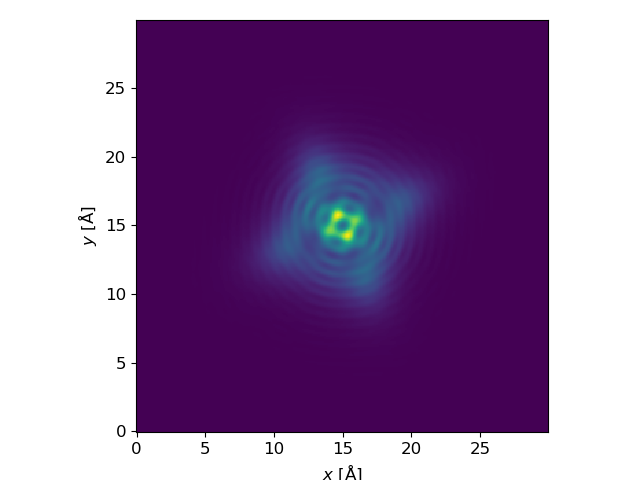

In [58]:
probe.show()

## Setup the scan 

First we define the detectors, in this case just a pixelated_detector aka camera for 4D STEM 

In [59]:
pixelated_detector = abtem.PixelatedDetector(max_angle=60)

Now we define the scan parameters and compute the multislice reconstruction giving us the 4D data set. This takes a couple of seconds, but can be also much longer with thicker materials and larger scans

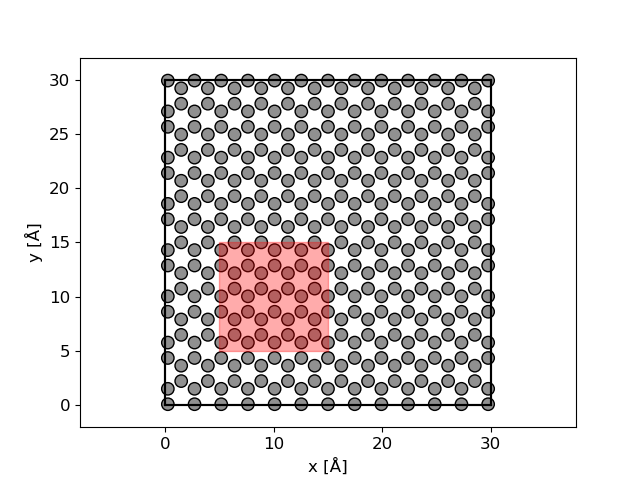

In [60]:
scan_sampling = 0.25 #A/px

grid_scan = abtem.GridScan(
    start=[5, 5],
    end=[15,15],
    sampling=scan_sampling,
    potential=potential,
    )

pixelated_measurements = probe.scan(
    potential,
    scan=grid_scan,
    detectors=pixelated_detector,
)

fig, ax = abtem.show_atoms(atoms)
grid_scan.add_to_plot(ax)

## Run the multislice simulation

In [61]:
pixelated_measurements.compute()

[########################################] | 100% Completed | 1.89 sms


### View PACBED

Adjust power to change the contrast and see CBED disks

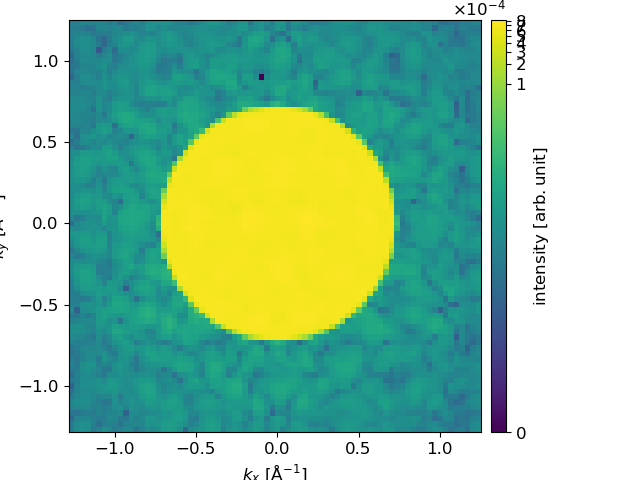

In [62]:
pixelated_measurements.show(power=0.08, cbar=True)

save the simulated ABTEM data

In [63]:
pixelated_measurements.to_zarr('4D_data.zarr')

[########################################] | 100% Completed | 107.21 ms


[[None]]

## Set finite dose

Apply a finte electron dose using Poisson statistics (in e/Å2)

In [64]:
pixelated_measurements = abtem.from_zarr('4D_data.zarr').compute()
#dose = 1e6 # in e/Å2 a normal high dose 
dose = 1e9 # a very high dose
dose = 1e15 # a very high dose
pixelated_measurements = pixelated_measurements.poisson_noise(dose_per_area=dose)

[########################################] | 100% Completed | 103.03 ms


see what the PACBED looks like at this dose

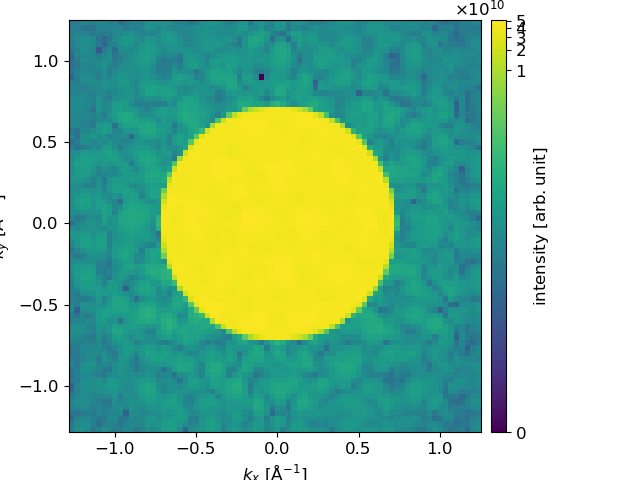

In [65]:
pixelated_measurements.show(power=0.08, cbar=True)

### save the resulting 4D STEM data

In [66]:
# Saving dataset
data_dict = {
    'data_4D': np.float32(pixelated_measurements.array),
    'scan_step_size': scan_sampling,
    'aperture_size': semiangle_cutoff/1e3, #rad
    'voltage': energy/1e3, #kV
    'dose': dose
}
#filename = f'Graphene_{int(energy/1000)}kV_{int(semiangle_cutoff)}mrad_dose_{int(dose)}.npy' #use to autoname
filename = f'Graphene_current.npy'
np.save(filename, data_dict)

## Single Side Band with pytychoSTEM 

We now use pyptychostem to apply SSB on the data. The intensity in a Ronchigram is the modulus squared of the wavefunction of the fast electrons at the back focal plane, $|\Psi(K_f,R_p)|^2$, where Kf denotes the angle or position on the
Ronchigram and Rp the probe position. 

In [67]:
import sys
sys.path.append('./pyptychostem/') # path to pyptychostem
#sys.path.append('./Songge_1') # path to songge code
from STEM4D import *
#%matplotlib widget

#data_4D = Data4D(parfile,data=data)
#data_4D.center_ronchigrams()
#data_4D.estimate_aperture_size()
#s = data_4D.plot_4D()

In [68]:
filename = 'Graphene_current.npy'
data = np.load(filename, allow_pickle=True).item()
parfile = {'aperture': data['aperture_size'], #rad
           'voltage': data['voltage'], #kV
           'stepsize': data['scan_step_size'], #A/px
           'workers': 1, #for CPU parallelism, >1 only supported for linux
           'threshold': 0.2} #threshold for finding the BF disk, usually between 0.2 and 0.4
data_4D = Data4D(parfile, data=data['data_4D'])
data_4D.bin_Q(bin_factor=1) #optionally bin the detector 
data_4D.estimate_aperture_size()
data_4D.truncate_ronchigram(expansion_ratio=1) # crops ronchigram to the BF disk

{'aperture': 0.035, 'voltage': 60.0, 'stepsize': 0.25, 'workers': 1, 'threshold': 0.2}
dataset size:	 (40, 40, 76, 76)


## Fourier transform to obtain $G(K_f,Q_p)$

Now we Fourier transform the CBED patterns with respect to probe position to obtain $G(K_f,Q_p)$ where Qp is spatial frequency of object transmission function, Kf is the detector pixel

In [69]:
data_4D.apply_FT()

Now we can plot the power spectrum, which shows which spatial frequencies have the strongest amplitude based on the double disk overlaps

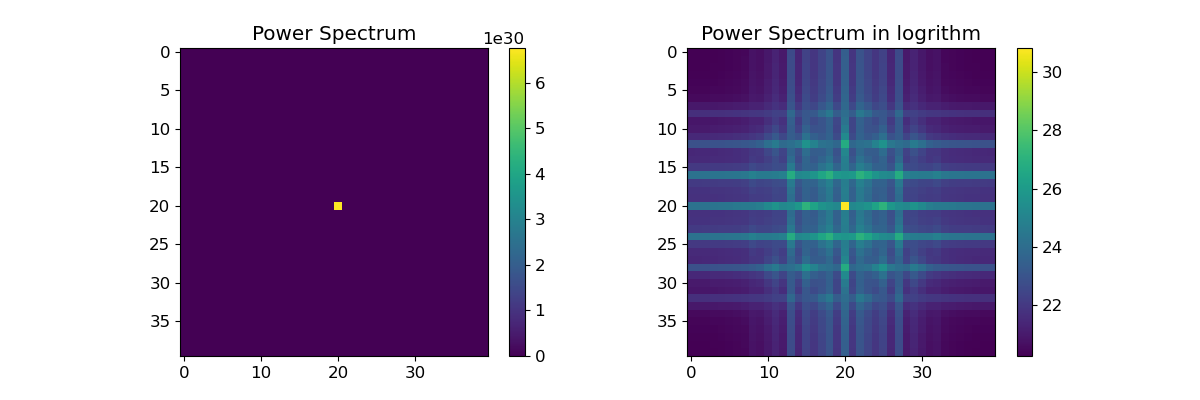

In [70]:
data_4D.plot_FT()

Below we plot $G(K_f,Q_p)$ with the highest intensities. Here we can match the rotation angle and the scan step size in order to match the circles with the intensity in the disk overlaps.

it is important to adjust the calibration parameters or the code will not select the double disk overlaps correctly

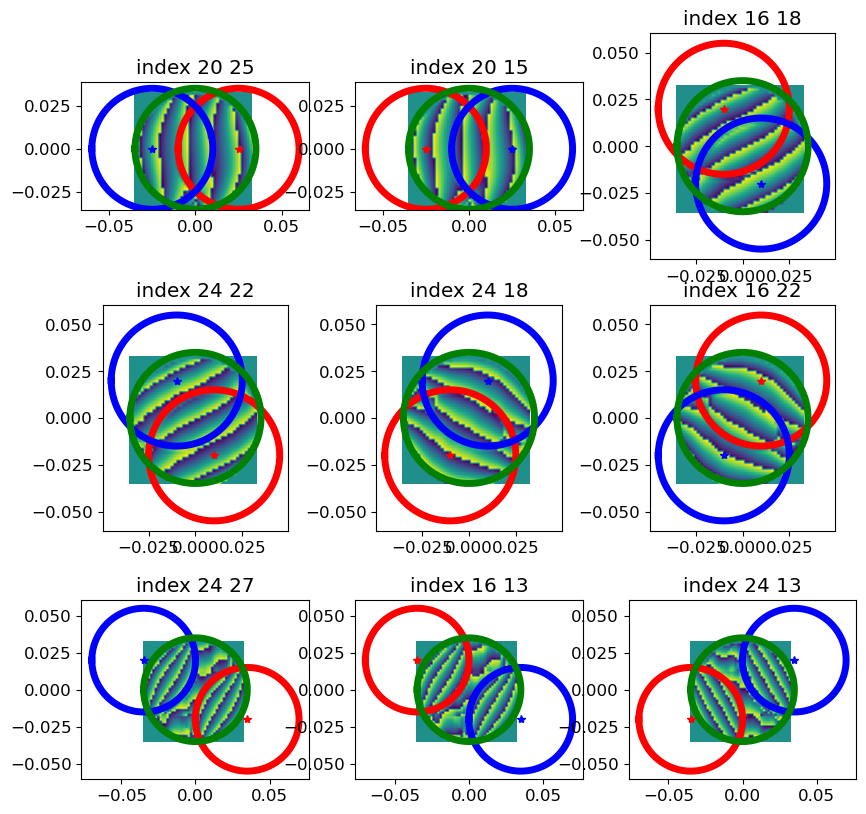

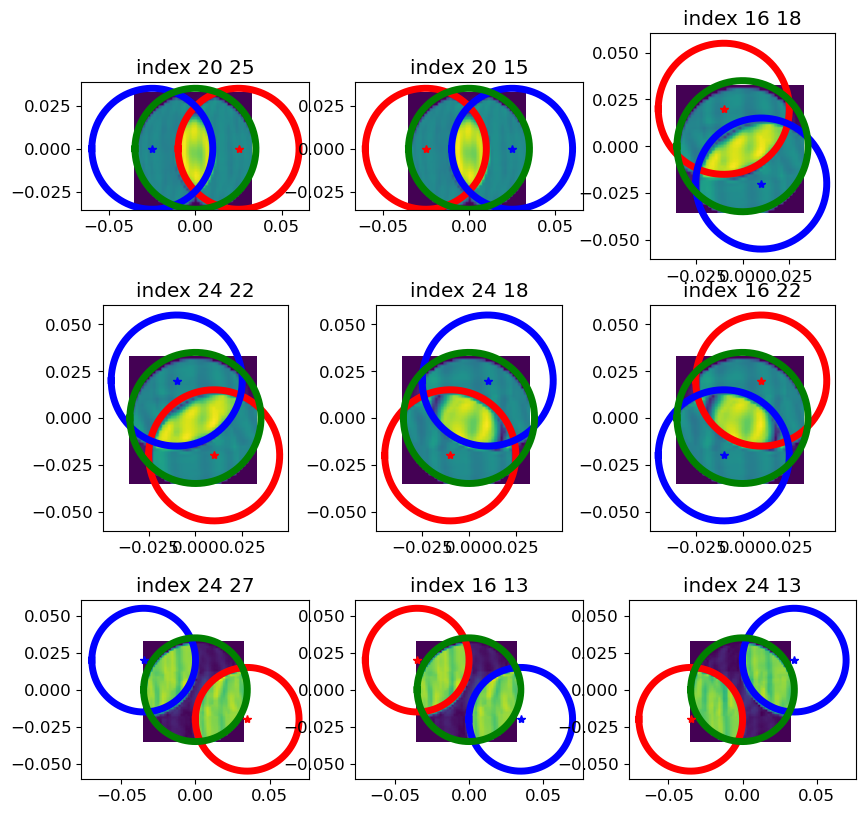

In [72]:
## change these to adjust double disk overlaps 
rotation = 0
#data_4D.voltage= 200/1000  #kV
#data_4D.step_size = 0.25
#data_4D.step_size = 0.5
#data_4D.setup_scanning_parameters() #require this line to make adjustments of step size active
%matplotlib inline 
#%matplotlib widget seems to have an issue overlaying the two figures
data_4D.plot_trotters(rotation_angle=rotation,skip=1)
#data_4D.plot_trotters(skip=1) #for songge code use this instead

## 4D Data Navigator exploration

### real space

The 4D data navigator below allows you to explore the Ronchigram / CBED as a function of probe position by dragging the red box in the left figure which displays in integrated BF signal  

In [73]:
#real space
%matplotlib widget 
data_4D.plot_4D()

<Signal2D, title: 4D data, dimensions: (40, 40|76, 76)>

### Reciprical space $G(K_f,Q_p)$

The 4D data navigator below allows you to explore $G(K_f,Q_p)$ as function of spatial frequency (Qp) by dragging the red box in the left figure which displays the power spectrum (when the amplitude is shown).

Switch between showing the phase and amplitude to compare

In [74]:
%matplotlib widget 
data_4D.plot_4D_reciprocal_both()

<Signal2D, title: FT of 4D data, dimensions: (40, 40, 2|43, 43)>

## Run the actual SSB

Now we can run the integration of one of the overlaps and extract the phase (and amplitude) of the resulting complex image .

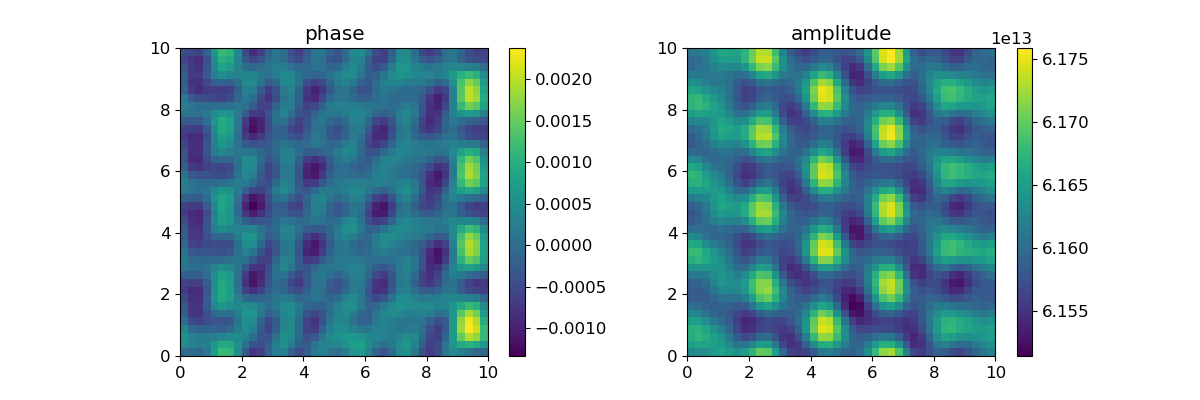

In [75]:
ssb = SSB(data_4D)
ssb.run()
ssb.plot_result()

We can calculate the aberration coefficients using singular value decomposition. For this, the double disk overlaps of the trotters with the highest intensities are selected.

In [76]:
svd = SVD_AC(data_4D,trotters_nb=9)
coeffs = svd.run_svd(iterations=5,order=3,cf=0.5)


In [36]:
svd.print_aberration_coefficients(coeffs)

C10  =  10.005  nm
C12a =  -28.858  nm
C12b =  -0.055  nm
C21a =  -5.905  nm
C21b =  8.63  nm
C23a =  2.958  nm
C23b =  -3.815  nm
C30  =  -0.309  um
C32a =  0.47  um
C32b =  0.015  um
C34a =  -0.506  um
C34b =  0.013  um
C41a =  0.0  mm
C41b =  0.0  mm
C43a =  0.0  mm
C43b =  0.0  mm
C45a =  0.0  mm
C45b =  0.0  mm
C50  =  0.0  mm
C52a =  0.0  mm
C52b =  0.0  mm
C54a =  0.0  mm
C54b =  0.0  mm
C56a =  0.0  mm
C56b =  0.0  mm


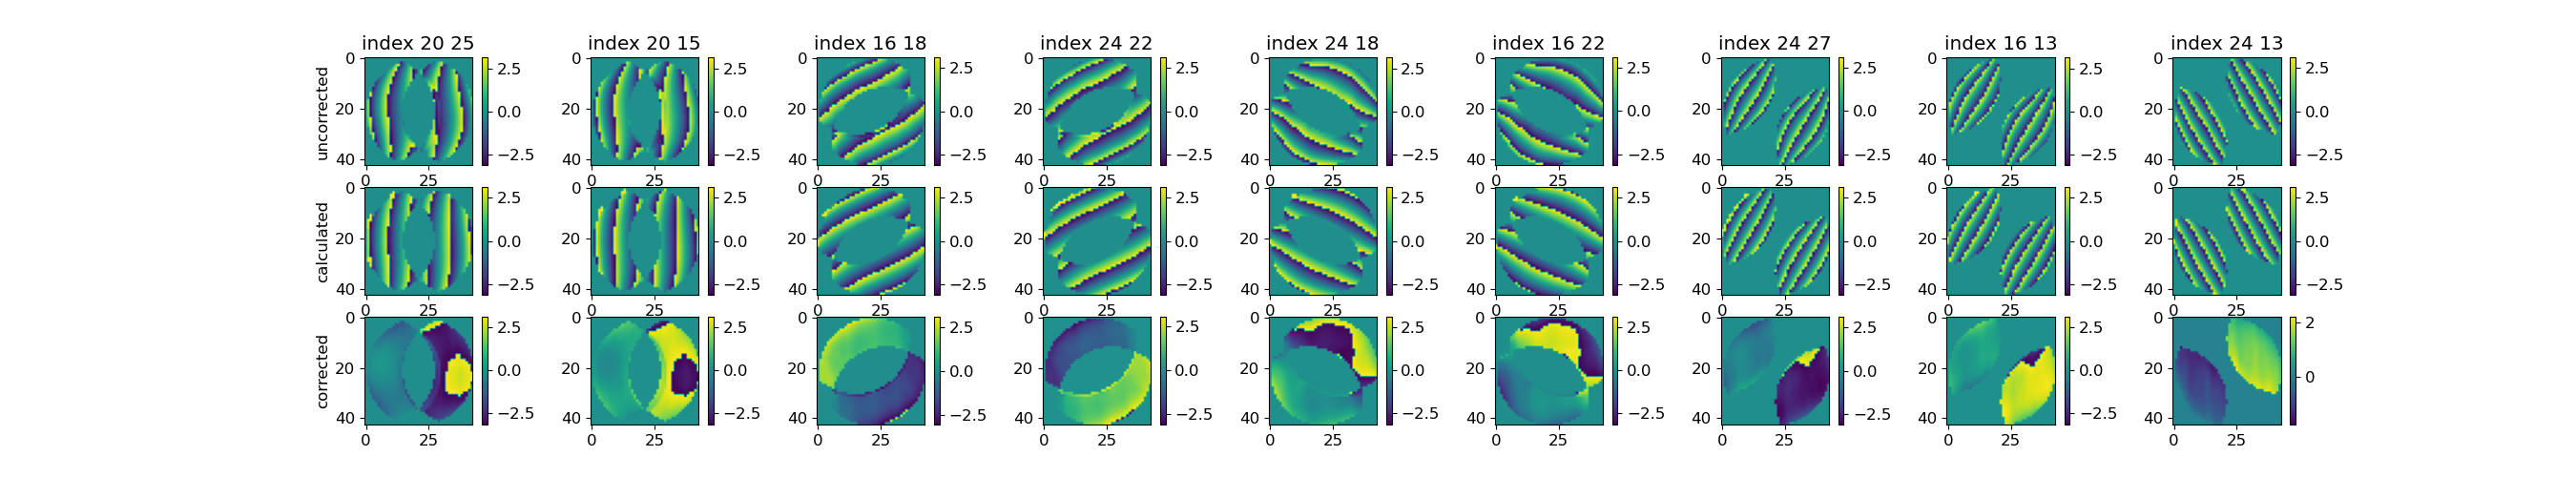

In [77]:
svd.plot_corrected_trotters(data_4D.selected_frames,coeffs)

In [78]:
ssb_ac = SSB(data_4D)
ssb_ac.run(aberrations = coeffs)


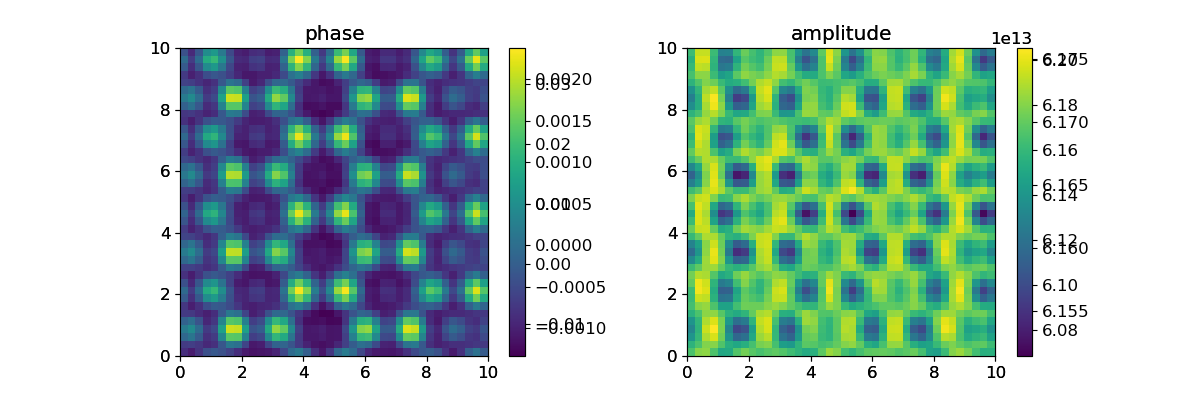

In [79]:
ssb_ac.plot_result()
